In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Data

In [2]:
# Load CFashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='data',
                                             train=True,
                                             download=True,
                                             transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1024,
                                          num_workers=10,
                                          shuffle=True,
                                          drop_last=True)

testset = torchvision.datasets.FashionMNIST(root='data',
                                            train=False,
                                            download= True,
                                            transform = transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1024,
                                         num_workers=10,
                                         shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 301kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.48MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


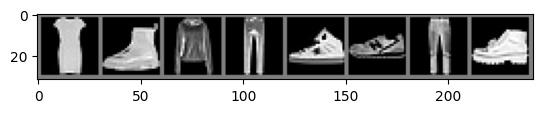

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img*0.5 + 0.5                                 # Decode image to give value [0,1]
  np_img = img.numpy()                                # tensor -> numpy array
  plt.imshow(np.transpose(np_img, (1, 2, 0)))         # default: (C-0, H-1, W-2) -> change to (H-1, W-2, C-0)
  plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
  imshow(torchvision.utils.make_grid(images[:8]))     # show 8 pics from a batch 
  break

Model

In [ ]:
model = nn.Sequential(                                      # A container to stack layers in order
    nn.Flatten(),           
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

for layer in model:
  if isinstance(layer, nn.Linear):                          # layer = Linear or not
    init.kaiming_uniform_(layer.weight, nonlinearity='relu')# Use He (or Kaiming initialization) method
    if layer.bias is not None:
      layer.bias.data.fill_(0)                              # Set bias (if any) to 0

model = model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)


Loss, Optimizer, and Evaluation Function

In [ ]:
criterion = nn.CrossEntropyLoss()                           # Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.0001)       # Adam - Optimization Algorithm

In [ ]:
def evaluate(model, testloader, criterion):
  model.eval()                                              # Switch model to evaluation mode -> turn off dropout and batch normalization
  test_loss = 0.0
  running_correct = 0
  total = 0
  with torch.no_grad():                                     # Turn off gradient calculation during evaluation
    for images, labels in testloader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)             # Get highest probability class from outputs.data
      total += labels.size(0)                               # Total samples
      running_correct += (predicted == labels).sum().item() # Cout the number of correct predictions

  accuracy = 100 * running_correct / total                  # Calculate accuracy
  test_loss = test_loss / len(testloader)                   # Calculate Avg_loss
  return test_loss, accuracy

Train

In [7]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 250

In [ ]:
for epoch in range(max_epoch):
  model.train()                                             # train model
  running_loss = 0.0
  running_correct = 0
  total = 0

  for i, (inputs, labels) in enumerate(trainloader, 0):
    inputs, labels = inputs.to(device), labels.to(device)   # transfer batches of images and labels to GPU

    optimizer.zero_grad()                                   # Pytorch retain old gradients, so set gradients of all to 0

    outputs = model(inputs)
    loss = criterion(outputs, labels)                       # Calculate loss
    running_loss += loss.item()                             # Cumulative loss value

    _, predicted = torch.max(outputs.data, 1)               
    total += labels.size(0)
    running_correct += (predicted == labels).sum().item()

    loss.backward()                                         # Calculate gradient based on loss
    optimizer.step()                                        # Update model weights based on calculated gradient

  epoch_accuracy = 100* running_correct/total               # Calculate epoch_accuracy in current epoch
  epoch_loss = running_loss / (i+1)                         # Calculate epoch_loss in current epoch

  test_loss, test_accuracy = evaluate(model, testloader, criterion) # Calculate test_loss and test_accuracy
  #print
  print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

  # append for plot
  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/250], Loss: 1.3229, Accuracy: 56.09%, Test Loss: 0.8184, Test Accuracy: 71.58%
Epoch [2/250], Loss: 0.7064, Accuracy: 75.68%, Test Loss: 0.6494, Test Accuracy: 77.18%
Epoch [3/250], Loss: 0.5943, Accuracy: 79.29%, Test Loss: 0.5812, Test Accuracy: 79.58%
Epoch [4/250], Loss: 0.5380, Accuracy: 81.33%, Test Loss: 0.5415, Test Accuracy: 80.80%
Epoch [5/250], Loss: 0.5023, Accuracy: 82.62%, Test Loss: 0.5151, Test Accuracy: 81.79%
Epoch [6/250], Loss: 0.4784, Accuracy: 83.40%, Test Loss: 0.4962, Test Accuracy: 82.69%
Epoch [7/250], Loss: 0.4587, Accuracy: 84.01%, Test Loss: 0.4823, Test Accuracy: 83.28%
Epoch [8/250], Loss: 0.4428, Accuracy: 84.56%, Test Loss: 0.4698, Test Accuracy: 83.54%
Epoch [9/250], Loss: 0.4304, Accuracy: 85.03%, Test Loss: 0.4589, Test Accuracy: 83.77%
Epoch [10/250], Loss: 0.4194, Accuracy: 85.43%, Test Loss: 0.4510, Test Accuracy: 83.90%
Epoch [11/250], Loss: 0.4098, Accuracy: 85.73%, Test Loss: 0.4432, Test Accuracy: 84.31%
Epoch [12/250], Loss: 0.4013, 

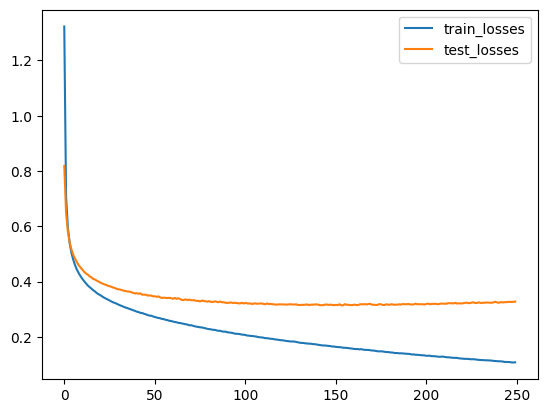

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

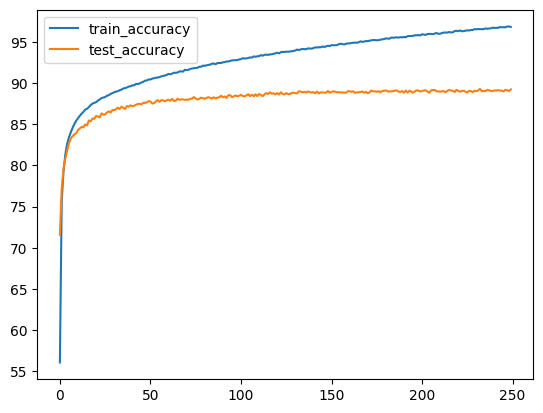

In [10]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()